In [53]:
import scipy,io
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, SimpleRNN, Input, TimeDistributed, GRU, LSTM
from tensorflow.keras.optimizers import AdamW, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import L1, L2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, normalize, MinMaxScaler
from sklearn.decomposition import PCA
import math
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

mat = scipy.io.loadmat('../UNT-Thermography-24/GaN_data/data_GaN_8_15micron_1.mat')
mat2 = scipy.io.loadmat('../UNT-Thermography-24/GaN_data/data_GaN_8_15micron_2.mat')
mat3 = scipy.io.loadmat('../UNT-Thermography-24/GaN_data/data_GaN_8_15micron_3.mat')


temp_comb = np.concatenate((mat.get('T_GaN_random'), mat2.get('T_GaN_random'), mat3.get('T_GaN_random')), axis=2)
spectra_comb = np.concatenate((mat.get('Spectrum'), mat2.get('Spectrum'), mat3.get('Spectrum')), axis=2)


X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()

samples = spectra_comb.shape[2]

reshaped_spectra = spectra_comb.reshape(-1, samples).T
reshaped_temp = temp_comb.reshape(-1, samples).T

X_train, X_test, y_train, y_test = train_test_split(reshaped_spectra, reshaped_temp, train_size=0.8, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, random_state=42)

X_train = X_train.T.reshape(spectra_comb.shape[0], spectra_comb.shape[1], -1)
X_val = X_val.T.reshape(spectra_comb.shape[0], spectra_comb.shape[1], -1)
X_test = X_test.T.reshape(spectra_comb.shape[0], spectra_comb.shape[1], -1)

y_train = y_train.T.reshape(temp_comb.shape[0], temp_comb.shape[1], -1)
y_val = y_val.T.reshape(temp_comb.shape[0], temp_comb.shape[1], -1)
y_test = y_test.T.reshape(temp_comb.shape[0], temp_comb.shape[1], -1)

X_train = X_train.transpose(2, 0, 1)
X_val = X_val.transpose(2, 0, 1)
X_test = X_test.transpose(2, 0, 1)

y_train = y_train.transpose(2, 0, 1)
y_val = y_val.transpose(2, 0, 1)
y_test = y_test.transpose(2, 0, 1)

# Fit and transform the input data (X_train)
X_train_scaled = X_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Transform the validation and test data using the same scaler
X_val_scaled = X_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = X_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Fit and transform the output data (y_train)
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)

# Transform the validation and test data using the same scaler
y_val_scaled = y_scaler.transform(y_val.reshape(-1, y_val.shape[-1])).reshape(y_val.shape)
y_test_scaled = y_scaler.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)



In [54]:
model = Sequential()
model.add(Input(shape=(5, 71)))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(16, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(10, activation='linear')))

model.summary()

nadam = Nadam(learning_rate=0.001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model.compile(optimizer=nadam, loss='mae', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train_scaled, epochs=100, validation_data=(X_val_scaled, y_val_scaled),
          callbacks=[early_stopping, reduce_lr])


test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 5, 256)         │       335,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 5, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 5, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 5, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 5, 16)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 5, 10)          │           170 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 598,122 (2.28 MB)

 Trainable params: 598,122 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.2883 - loss: 0.2445 - val_accuracy: 0.6499 - val_loss: 0.0417 - learning_rate: 0.0010
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6870 - loss: 0.0401 - val_accuracy: 0.6583 - val_loss: 0.0355 - learning_rate: 0.0010
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6734 - loss: 0.0360 - val_accuracy: 0.6170 - val_loss: 0.0383 - learning_rate: 0.0010
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6866 - loss: 0.0345 - val_accuracy: 0.7199 - val_loss: 0.0330 - learning_rate: 0.0010
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6976 - loss: 0.0331 - val_accuracy: 0.7092 - val_loss: 0.0315 - learning_rate: 0.0010
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7114 - loss: 0.0317 - val_accuracy: 0.7429 - val_loss: 0.0308 - learning_rate: 0.0010
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7293 - l

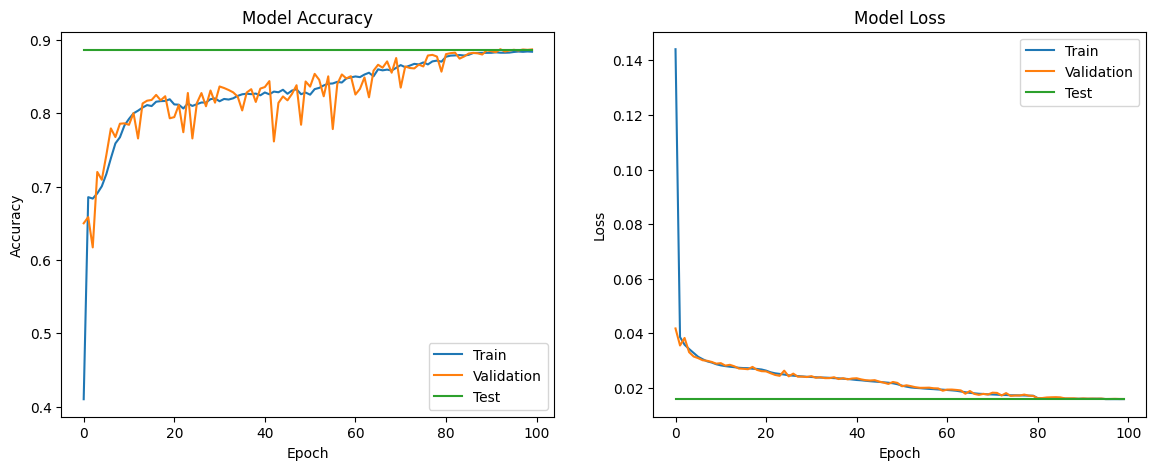

In [55]:
history.history['test_accuracy'] = [test_accuracy] * len(history.history['accuracy'])
history.history['test_loss'] = [test_loss] * len(history.history['loss'])

# Plot loss and accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.plot(history.history['test_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.plot(history.history['test_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [56]:
# Make predictions
y_pred = model.predict(X_test_scaled)
print(f'Prediction shape: {y_pred.shape}')

# Reshape the predicted outputs to match the original shape
y_pred_rescaled = y_pred.reshape(-1, y_pred.shape[-1])

# Inverse transform the predicted outputs
y_pred_original_scale = y_scaler.inverse_transform(y_pred_rescaled).reshape(y_pred.shape)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Prediction shape: (2000, 5, 10)


In [57]:
temp_diff = y_test - y_pred_original_scale

In [58]:
max = np.max(np.abs(temp_diff))
min = np.min(np.abs(temp_diff))

In [59]:
max

40.675646387010545

In [60]:
min

1.9926500272049452e-07

In [61]:
# Select a random index for a 5x10 segment
random_index = np.random.randint(0, len(y_test))
actual_segment = y_test[random_index]
predicted_segment = y_pred_original_scale[random_index]

In [62]:
temp_T = temp_comb.transpose(2, 0, 1)

In [63]:
transposed = temp_T[0]

In [64]:
original = temp_comb[:, :, 0]

In [65]:
transposed - original

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

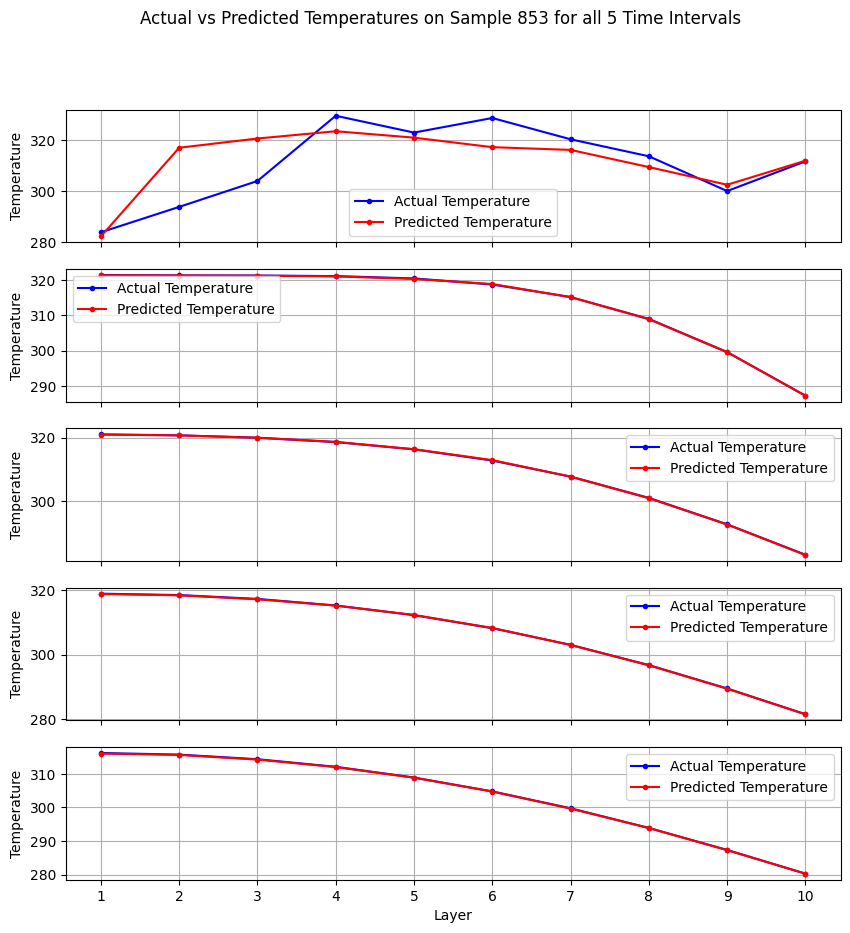

In [66]:
# Select a random index for a 5x10 segment
random_index = np.random.randint(0, len(y_test))
actual_segment = y_test[random_index]
predicted_segment = y_pred_original_scale[random_index]

x = range(1, 11)

# Plot the selected segments
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
for i in range(5):
    axs[i].plot(x, actual_segment[i], 'b.-', label='Actual Temperature')
    axs[i].plot(x, predicted_segment[i], 'r.-', label='Predicted Temperature')
    plt.xlabel('Layer')
    plt.xticks(np.arange(1, 11, step=1))
    axs[i].set_ylabel('Temperature')
    axs[i].legend()
    axs[i].grid(True)

plt.xlabel('Layer')
plt.suptitle(f"Actual vs Predicted Temperatures on Sample {random_index} for all 5 Time Intervals")
plt.show()

In [79]:
# Calculate absolute difference
temp_diff_abs = np.abs(y_test - y_pred_original_scale)

In [80]:
# Sum all test matrices into one 5 by 10 matrix
temp_diff_2d = np.sum(temp_diff_abs, axis=0)

# Average absolute temperature difference per layer in each time instance
avg_temp_time = temp_diff_2d / 2000

# Sum columns together and find mean
avg_temp_diff = np.sum(temp_diff_2d, axis=0) / 10000

In [86]:
avg_temp_diff

array([0.89636818, 2.04875126, 1.92467664, 1.35510143, 1.63058614,
       1.32419643, 1.40970519, 1.35643276, 0.78555374, 0.21146107])

In [87]:
global_avg_diff = np.mean(avg_temp_diff)